In [1]:
import glob

import librosa
from librosa import display
from IPython.display import Audio
import matplotlib.pyplot as plt

from fastai_audio.audio import (
    Path,
    SpectrogramConfig,
    AudioItem,
    AudioConfig,
    AudioList,
    audio_learner,
    audio_predict,
    ClassificationInterpretation,
    get_spectro_transforms,
)

from fastai.vision import load_learner

import numpy as np
import torch

/usr/local/lib/python3.7/dist-packages/librosa/filters.py:222: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


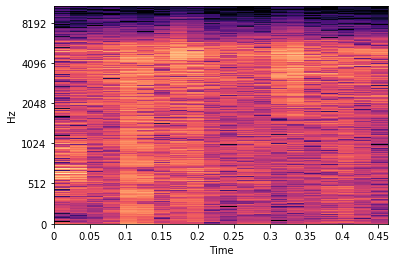

In [2]:
import glob

file_list = glob.glob(f"/data/NRS10/2015-2016/*.wav")
file_list.sort()

y, sr = librosa.load(
    "output/damselfish/78.wav",
    sr=5000
)

sg1 = librosa.feature.melspectrogram(
    y,
    n_fft=128,
    hop_length=16,
    power=1.0,
    n_mels=128, 
    fmin=200, 
    fmax=1000
)

sg = librosa.feature.melspectrogram(y, sr=sr, power=1.0)
sg0 = librosa.stft(y)
sg_mag, sg_phase = librosa.magphase(sg0)

#sg1 = librosa.feature.melspectrogram(S=sg_mag, sr=5000)
#librosa.display.specshow(sg1)

db_spec = librosa.amplitude_to_db(sg_mag, ref=np.min, top_db=60.0)
librosa.display.specshow(db_spec, y_axis='mel', x_axis='time')


#Image.show(torch.from_numpy(sg2).unsqueeze(0), figsize=(15, 5), cmap=None)

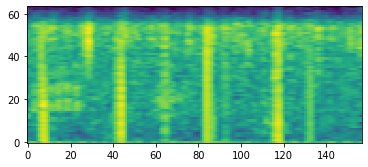

In [3]:
import torchaudio

from torchaudio.transforms import MelSpectrogram, AmplitudeToDB, MFCC

sig, sr = torchaudio.load(
    "output/damselfish/40.wav",
)

mel = MelSpectrogram(
    f_min=200.0,
    f_max=1500,
    hop_length=64,
    n_fft=512,
    n_mels=64,
    pad=0,
    win_length=None
)(sig)

mel = AmplitudeToDB(top_db=50)(mel)
mel = mel.detach()

plt.figure()
p = plt.imshow(mel[0,:,:].detach().numpy(), origin="lower")

In [26]:
path = Path("output/")

#sg = librosa.feature.melspectrogram(y, sr=sr,  n_fft=1024, hop_length=256, power=2.0, n_mels=64, fmin=0.0, fmax=2500)
#db_spec = librosa.amplitude_to_db(sg, ref=1.0, amin=1e-04, top_db=40.0)
#librosa.display.specshow(db_spec, y_axis='mel', fmax=2500, hop_length=256, x_axis='time')

#sg_cfg = SpectrogramConfig()
sg_cfg = SpectrogramConfig(
    f_max=2500., 
    f_min=200.,
    top_db=60,
    hop_length=64,
    n_fft=512,
    n_mels=64,
    pad=0,
)

config = AudioConfig(
    cache=False,
    use_spectro=True,
    sg_cfg=sg_cfg,
)

#label_pattern = r'_([mf]\d+)_'
al = AudioList.from_folder(path, config=config).split_by_rand_pct(.2, seed=4).label_from_folder()
#al = AudioList.from_folder(path, config=config).split_by_rand_pct(.2, seed=4).label_const("damselfish")

------------------------------------------------------------
File: output/damselfish/60.wav
Total Length: 2.0 seconds
Number of Channels: 1
Label: damselfish


Channel 0.0 (128x314):


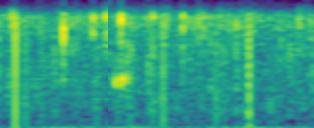

------------------------------------------------------------
File: output/damselfish/125.wav
Total Length: 2.0 seconds
Number of Channels: 1
Label: damselfish


Channel 0.0 (128x314):


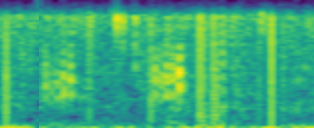

------------------------------------------------------------
File: output/damselfish/18.wav
Total Length: 2.0 seconds
Number of Channels: 1
Label: damselfish


Channel 0.0 (128x314):


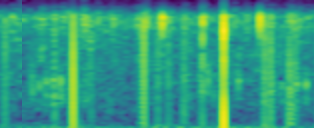

------------------------------------------------------------
File: output/damselfish/199.wav
Total Length: 2.0 seconds
Number of Channels: 1
Label: damselfish


Channel 0.0 (128x314):


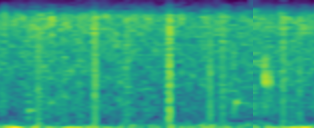

------------------------------------------------------------
File: output/damselfish/162.wav
Total Length: 2.0 seconds
Number of Channels: 1
Label: damselfish


Channel 0.0 (128x314):


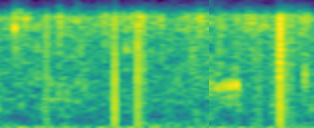

------------------------------------------------------------
File: output/damselfish/124.wav
Total Length: 2.0 seconds
Number of Channels: 1
Label: damselfish


Channel 0.0 (128x314):


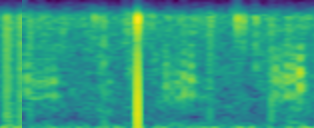

------------------------------------------------------------
File: output/damselfish/20151026-220348542.wav
Total Length: 2.0 seconds
Number of Channels: 1
Label: damselfish


Channel 0.0 (128x314):


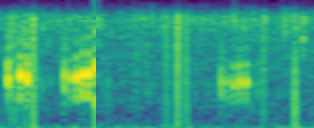

------------------------------------------------------------
File: output/damselfish/143.wav
Total Length: 2.0 seconds
Number of Channels: 1
Label: damselfish


Channel 0.0 (128x314):


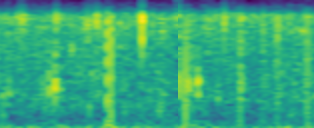

------------------------------------------------------------
File: output/damselfish/132.wav
Total Length: 2.0 seconds
Number of Channels: 1
Label: damselfish


Channel 0.0 (128x314):


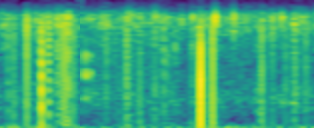

------------------------------------------------------------
File: output/damselfish/20150618-786.wav
Total Length: 2.0 seconds
Number of Channels: 1
Label: damselfish


Channel 0.0 (128x314):


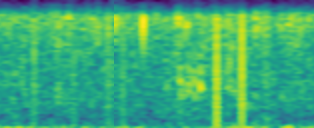

In [31]:
#tfms = get_spectro_transforms(mask_time=False, mask_freq=True, roll=False, num_rows=12)
tfms = None
tfms = get_spectro_transforms(
    size=(128, 314), # Upscale the spectrograms from 128, 39
    mask_frequency=False, # Don't mask frequencies
    mask_time=False # Don't mask time
)
db = al.transform(tfms).databunch(bs=10)
db.show_batch(10)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


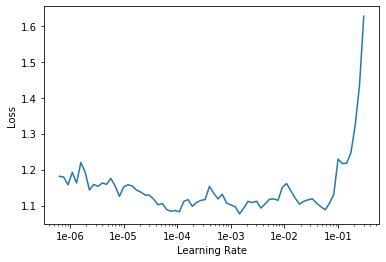

In [32]:
from fastai.vision import models

learn = audio_learner(db, base_arch=models.densenet161)

#learn = cnn_learner(db, models.densenet161, metrics=accuracy, callback_fns=ShowGraph, pretrained=True).mixup()

#learn = cnn_learner(db, models.densenet161, metrics=accuracy)

learn.lr_find()
learn.recorder.plot()

In [33]:
learn.fit_one_cycle(25, slice(1e-2))

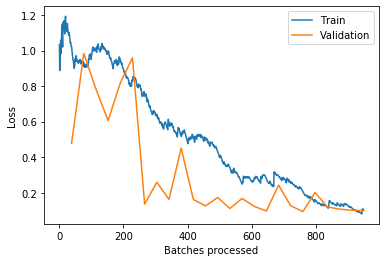

In [34]:
learn.recorder.plot_losses()

In [15]:
learn.save("/workspaces/sonumator/stage1-better-spectrograms-978")

In [22]:
#learn.save("/workspaces/sonumator/stage1")
learn.unfreeze()

learn.fit_one_cycle(3, slice(1e-2/10))

In [18]:
learn = audio_learner(db)
learn.load("/workspaces/sonumator/stage1")

Learner(data=AudioDataBunch;

Train: AudioLabelList (332 items)
x: AudioList
AudioItem 0.67 seconds (1 channels, 3349 samples @ 5000hz),AudioItem 0.78 seconds (1 channels, 3899 samples @ 5000hz),AudioItem 0.8 seconds (1 channels, 4014 samples @ 5000hz),AudioItem 0.63 seconds (1 channels, 3149 samples @ 5000hz),AudioItem 0.71 seconds (1 channels, 3550 samples @ 5000hz)
y: CategoryList
damselfish,damselfish,damselfish,damselfish,damselfish
Path: output;

Valid: AudioLabelList (82 items)
x: AudioList
AudioItem 1.5 seconds (1 channels, 7500 samples @ 5000hz),AudioItem 1.5 seconds (1 channels, 7500 samples @ 5000hz),AudioItem 0.78 seconds (1 channels, 3905 samples @ 5000hz),AudioItem 0.68 seconds (1 channels, 3386 samples @ 5000hz),AudioItem 1.5 seconds (1 channels, 7500 samples @ 5000hz)
y: CategoryList
noise,noise,damselfish,damselfish,noise
Path: output;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [16]:
#learn = audio_learner(db, pretrained=True)
#learn.load("/workspaces/sonumator/stage2")
learn.model.eval()
learn.model.training = False

In [35]:
import torchaudio
import pandas as pd
import soundfile as sf
import os

def search_file_for_samples(filepath, model, offset=2):
    df = pd.DataFrame(columns=["start", "end", "filepath"])

    si, ei = torchaudio.info(filepath)
    length = si.length / si.rate

    for i in range(0, 1000, offset):
        end = i + offset

        y, sr = librosa.load(
            filepath,
            sr=5000,
            offset=i,
            duration=2,
        )
        tmpfile = f"potentials/{os.path.basename(filepath)[:-4]}-{i}.wav"
        sf.write(tmpfile, y, 5000)
        item = AudioItem(path=tmpfile)
        category, _, _ = audio_predict(learn, item)
        if str(category) == "damselfish":
            df = df.append([{"start": i, "end": end, "filepath": filepath}])
        else:
            os.remove(tmpfile)
        
    return df

df = search_file_for_samples("/data/NRS10/2015-2016/20151028-180505.wav", learn)
df.index = range(len(df.index))

In [36]:
df

start  end                                   filepath
0     12   14  /data/NRS10/2015-2016/20151028-180505.wav
1     28   30  /data/NRS10/2015-2016/20151028-180505.wav
2     30   32  /data/NRS10/2015-2016/20151028-180505.wav
3     70   72  /data/NRS10/2015-2016/20151028-180505.wav
4     80   82  /data/NRS10/2015-2016/20151028-180505.wav
5     82   84  /data/NRS10/2015-2016/20151028-180505.wav
6    102  104  /data/NRS10/2015-2016/20151028-180505.wav
7    106  108  /data/NRS10/2015-2016/20151028-180505.wav
8    108  110  /data/NRS10/2015-2016/20151028-180505.wav
9    116  118  /data/NRS10/2015-2016/20151028-180505.wav
10   118  120  /data/NRS10/2015-2016/20151028-180505.wav
11   126  128  /data/NRS10/2015-2016/20151028-180505.wav
12   134  136  /data/NRS10/2015-2016/20151028-180505.wav
13   146  148  /data/NRS10/2015-2016/20151028-180505.wav
14   148  150  /data/NRS10/2015-2016/20151028-180505.wav
15   174  176  /data/NRS10/2015-2016/20151028-180505.wav
16   182  184  /data/NRS10/2015-2016/20151028-180505.wav
17   184  186  /data/NRS10/2015-2016/20151028-180505.wav
18   186  188  /data/NRS10/2015-2016/20151028-180505.wav
19   196  198  /data/NRS10/2015-2016/20151028-180505.wav
20   240  242  /data/NRS10/2015-2016/20151028-180505.wav
21   246  248  /data/NRS10/2015-2016/20151028-180505.wav
22   252  254  /data/NRS10/2015-2016/20151028-180505.wav
23   284  286  /data/NRS10/2015-2016/20151028-180505.wav
24   350  352  /data/NRS10/2015-2016/20151028-180505.wav
25   372  374  /data/NRS10/2015-2016/20151028-180505.wav
26   374  376  /data/NRS10/2015-2016/20151028-180505.wav
27   392  394  /data/NRS10/2015-2016/20151028-180505.wav
28   410  412  /data/NRS10/2015-2016/20151028-180505.wav
29   418  420  /data/NRS10/2015-2016/20151028-180505.wav
30   420  422  /data/NRS10/2015-2016/20151028-180505.wav
31   426  428  /data/NRS10/2015-2016/20151028-180505.wav
32   446  448  /data/NRS10/2015-2016/20151028-180505.wav
33   448  450  /data/NRS10/2015-2016/20151028-180505.wav
34   480  482  /data/NRS10/2015-2016/20151028-180505.wav
35   482  484  /data/NRS10/2015-2016/20151028-180505.wav
36   514  516  /data/NRS10/2015-2016/20151028-180505.wav
37   534  536  /data/NRS10/2015-2016/20151028-180505.wav
38   540  542  /data/NRS10/2015-2016/20151028-180505.wav
39   584  586  /data/NRS10/2015-2016/20151028-180505.wav
40   596  598  /data/NRS10/2015-2016/20151028-180505.wav
41   624  626  /data/NRS10/2015-2016/20151028-180505.wav
42   628  630  /data/NRS10/2015-2016/20151028-180505.wav
43   646  648  /data/NRS10/2015-2016/20151028-180505.wav
44   690  692  /data/NRS10/2015-2016/20151028-180505.wav
45   692  694  /data/NRS10/2015-2016/20151028-180505.wav
46   694  696  /data/NRS10/2015-2016/20151028-180505.wav
47   702  704  /data/NRS10/2015-2016/20151028-180505.wav
48   722  724  /data/NRS10/2015-2016/20151028-180505.wav
49   738  740  /data/NRS10/2015-2016/20151028-180505.wav
50   756  758  /data/NRS10/2015-2016/20151028-180505.wav
51   770  772  /data/NRS10/2015-2016/20151028-180505.wav
52   786  788  /data/NRS10/2015-2016/20151028-180505.wav
53   806  808  /data/NRS10/2015-2016/20151028-180505.wav
54   830  832  /data/NRS10/2015-2016/20151028-180505.wav
55   858  860  /data/NRS10/2015-2016/20151028-180505.wav
56   866  868  /data/NRS10/2015-2016/20151028-180505.wav
57   894  896  /data/NRS10/2015-2016/20151028-180505.wav

In [37]:
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB, MFCC
from IPython.display import Audio

from os import listdir
from os.path import isfile, join

def show(filename):
  sig, sr = torchaudio.load(
      filename,
  )

  mel = MelSpectrogram(
      f_min=200.0,
      f_max=2500.0,
      hop_length=64,
      n_fft=512,
      n_mels=64,
      pad=0,
      win_length=None
  )(sig)

  mel = AmplitudeToDB(top_db=50)(mel)
  mel = mel.detach()

  print(f"Filename {filename}")
  plt.figure()
  plt.imshow(mel[0,:,:].detach().numpy(), origin="lower")
  plt.show()


Filename potentials/20151028-180505-102.wav


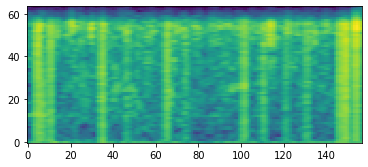

Filename potentials/20151028-180505-106.wav


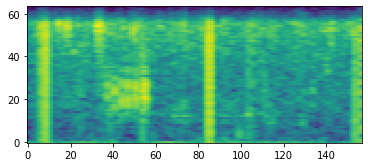

Filename potentials/20151028-180505-108.wav


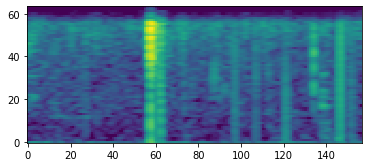

Filename potentials/20151028-180505-116.wav


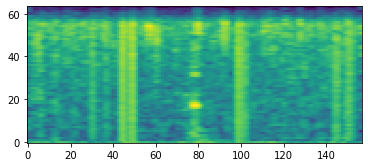

Filename potentials/20151028-180505-118.wav


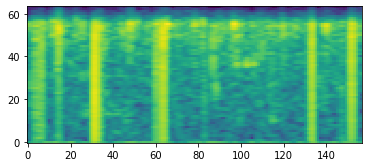

Filename potentials/20151028-180505-12.wav


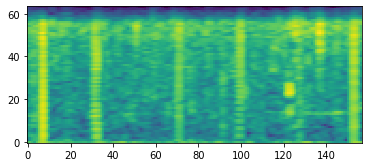

Filename potentials/20151028-180505-126.wav


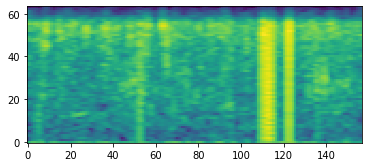

Filename potentials/20151028-180505-134.wav


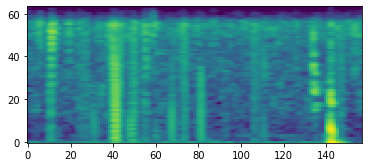

Filename potentials/20151028-180505-146.wav


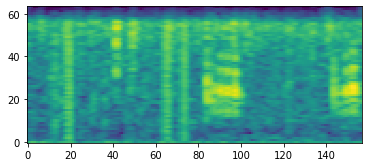

Filename potentials/20151028-180505-148.wav


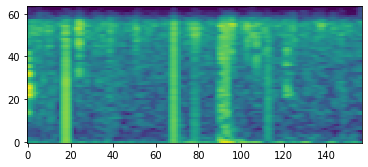

Filename potentials/20151028-180505-174.wav


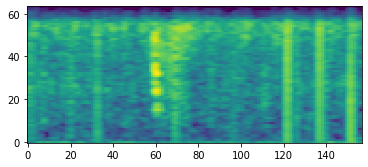

Filename potentials/20151028-180505-182.wav


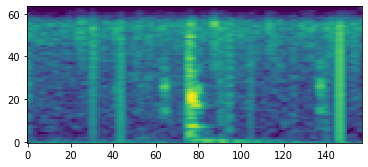

Filename potentials/20151028-180505-184.wav


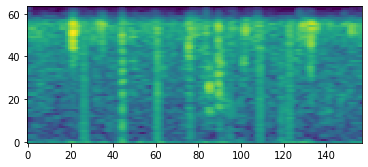

Filename potentials/20151028-180505-186.wav


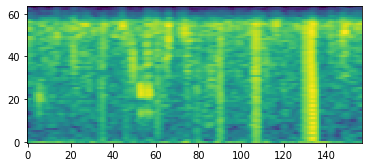

Filename potentials/20151028-180505-196.wav


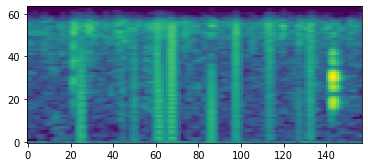

Filename potentials/20151028-180505-240.wav


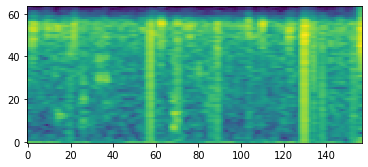

Filename potentials/20151028-180505-246.wav


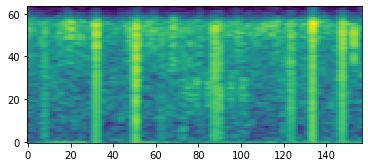

Filename potentials/20151028-180505-252.wav


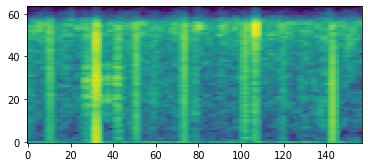

Filename potentials/20151028-180505-28.wav


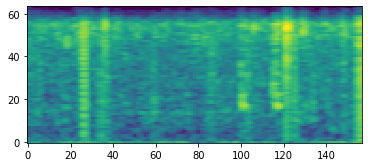

Filename potentials/20151028-180505-284.wav


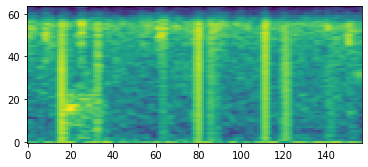

Filename potentials/20151028-180505-30.wav


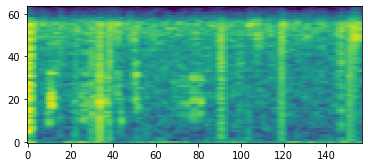

Filename potentials/20151028-180505-350.wav


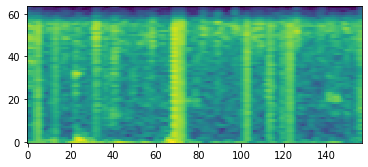

Filename potentials/20151028-180505-372.wav


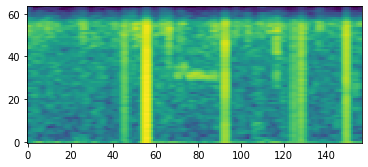

Filename potentials/20151028-180505-374.wav


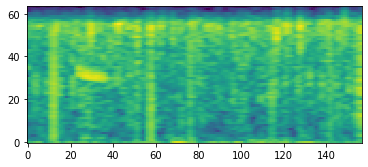

Filename potentials/20151028-180505-392.wav


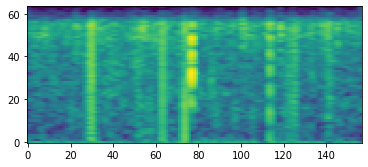

Filename potentials/20151028-180505-410.wav


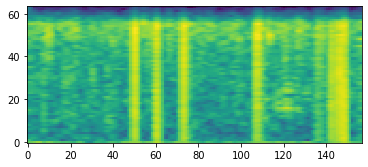

Filename potentials/20151028-180505-418.wav


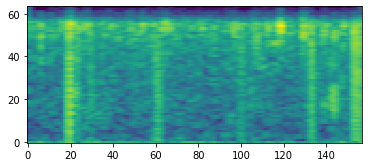

Filename potentials/20151028-180505-420.wav


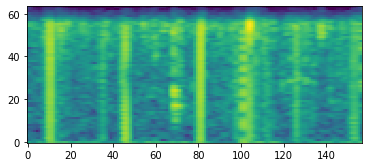

Filename potentials/20151028-180505-426.wav


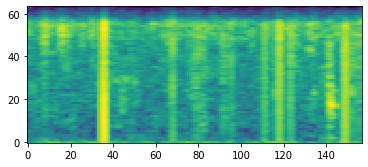

Filename potentials/20151028-180505-446.wav


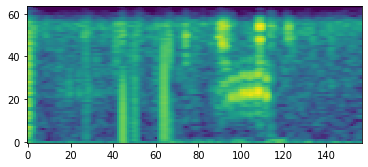

Filename potentials/20151028-180505-448.wav


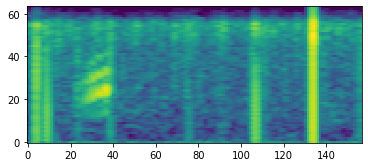

Filename potentials/20151028-180505-480.wav


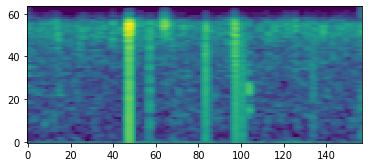

Filename potentials/20151028-180505-482.wav


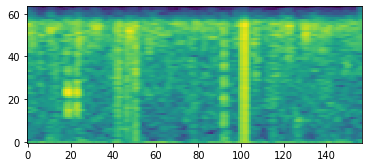

Filename potentials/20151028-180505-514.wav


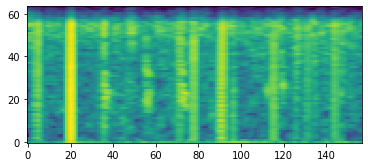

Filename potentials/20151028-180505-534.wav


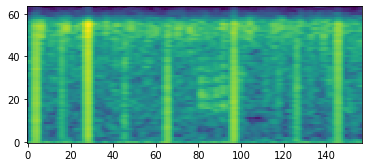

Filename potentials/20151028-180505-540.wav


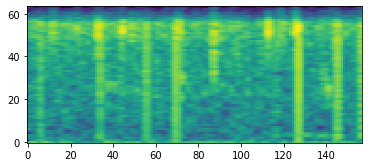

Filename potentials/20151028-180505-584.wav


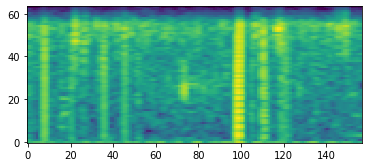

Filename potentials/20151028-180505-596.wav


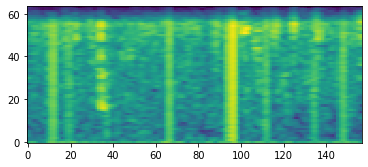

Filename potentials/20151028-180505-624.wav


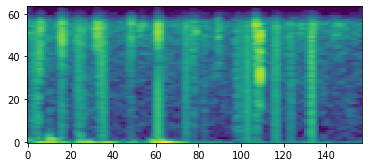

Filename potentials/20151028-180505-628.wav


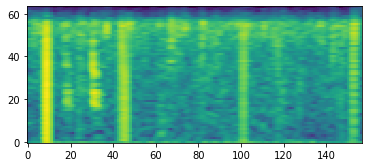

Filename potentials/20151028-180505-646.wav


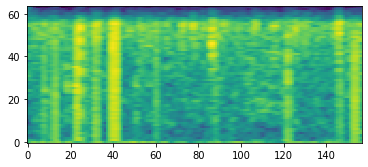

Filename potentials/20151028-180505-690.wav


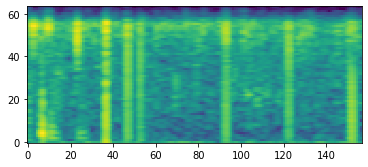

Filename potentials/20151028-180505-692.wav


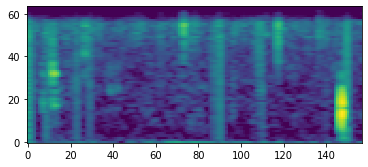

Filename potentials/20151028-180505-694.wav


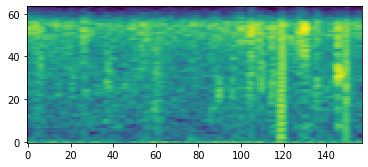

Filename potentials/20151028-180505-70.wav


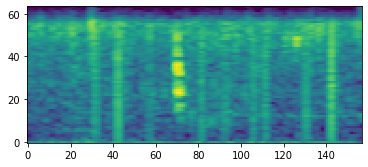

Filename potentials/20151028-180505-702.wav


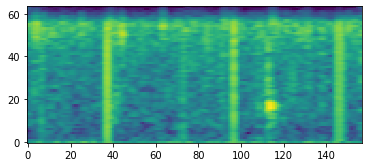

Filename potentials/20151028-180505-722.wav


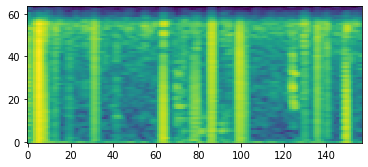

Filename potentials/20151028-180505-738.wav


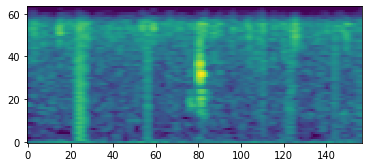

Filename potentials/20151028-180505-756.wav


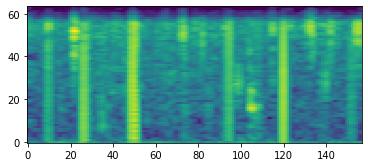

Filename potentials/20151028-180505-770.wav


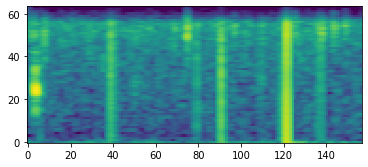

Filename potentials/20151028-180505-786.wav


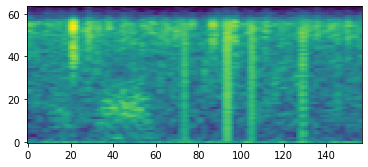

Filename potentials/20151028-180505-80.wav


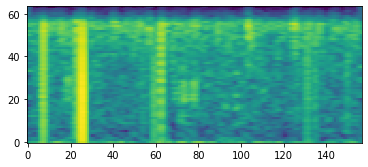

Filename potentials/20151028-180505-806.wav


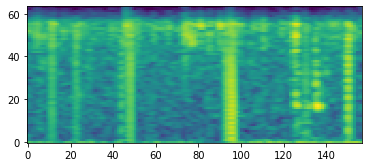

Filename potentials/20151028-180505-82.wav


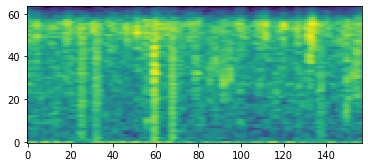

Filename potentials/20151028-180505-830.wav


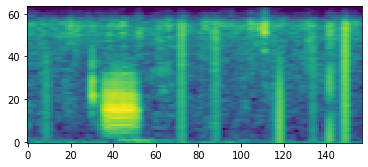

Filename potentials/20151028-180505-858.wav


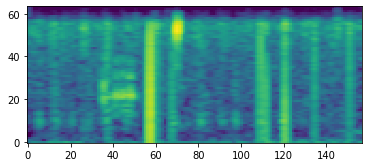

Filename potentials/20151028-180505-866.wav


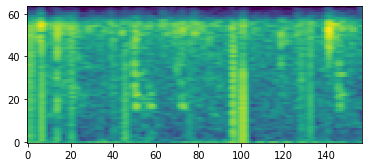

Filename potentials/20151028-180505-894.wav


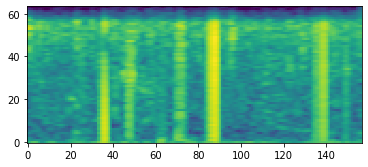

In [38]:
mypath = "potentials/"
potentials = [f"{mypath}{f}" for f in listdir(mypath) if isfile(join(mypath, f))]
potentials.sort()

for i in range(0, len(potentials)):
  show(potentials[i])

In [29]:
## Timeseries

In [31]:
import math
minute_counts = df.groupby('minute').count().iloc[:,0]

KeyError: 'minute'

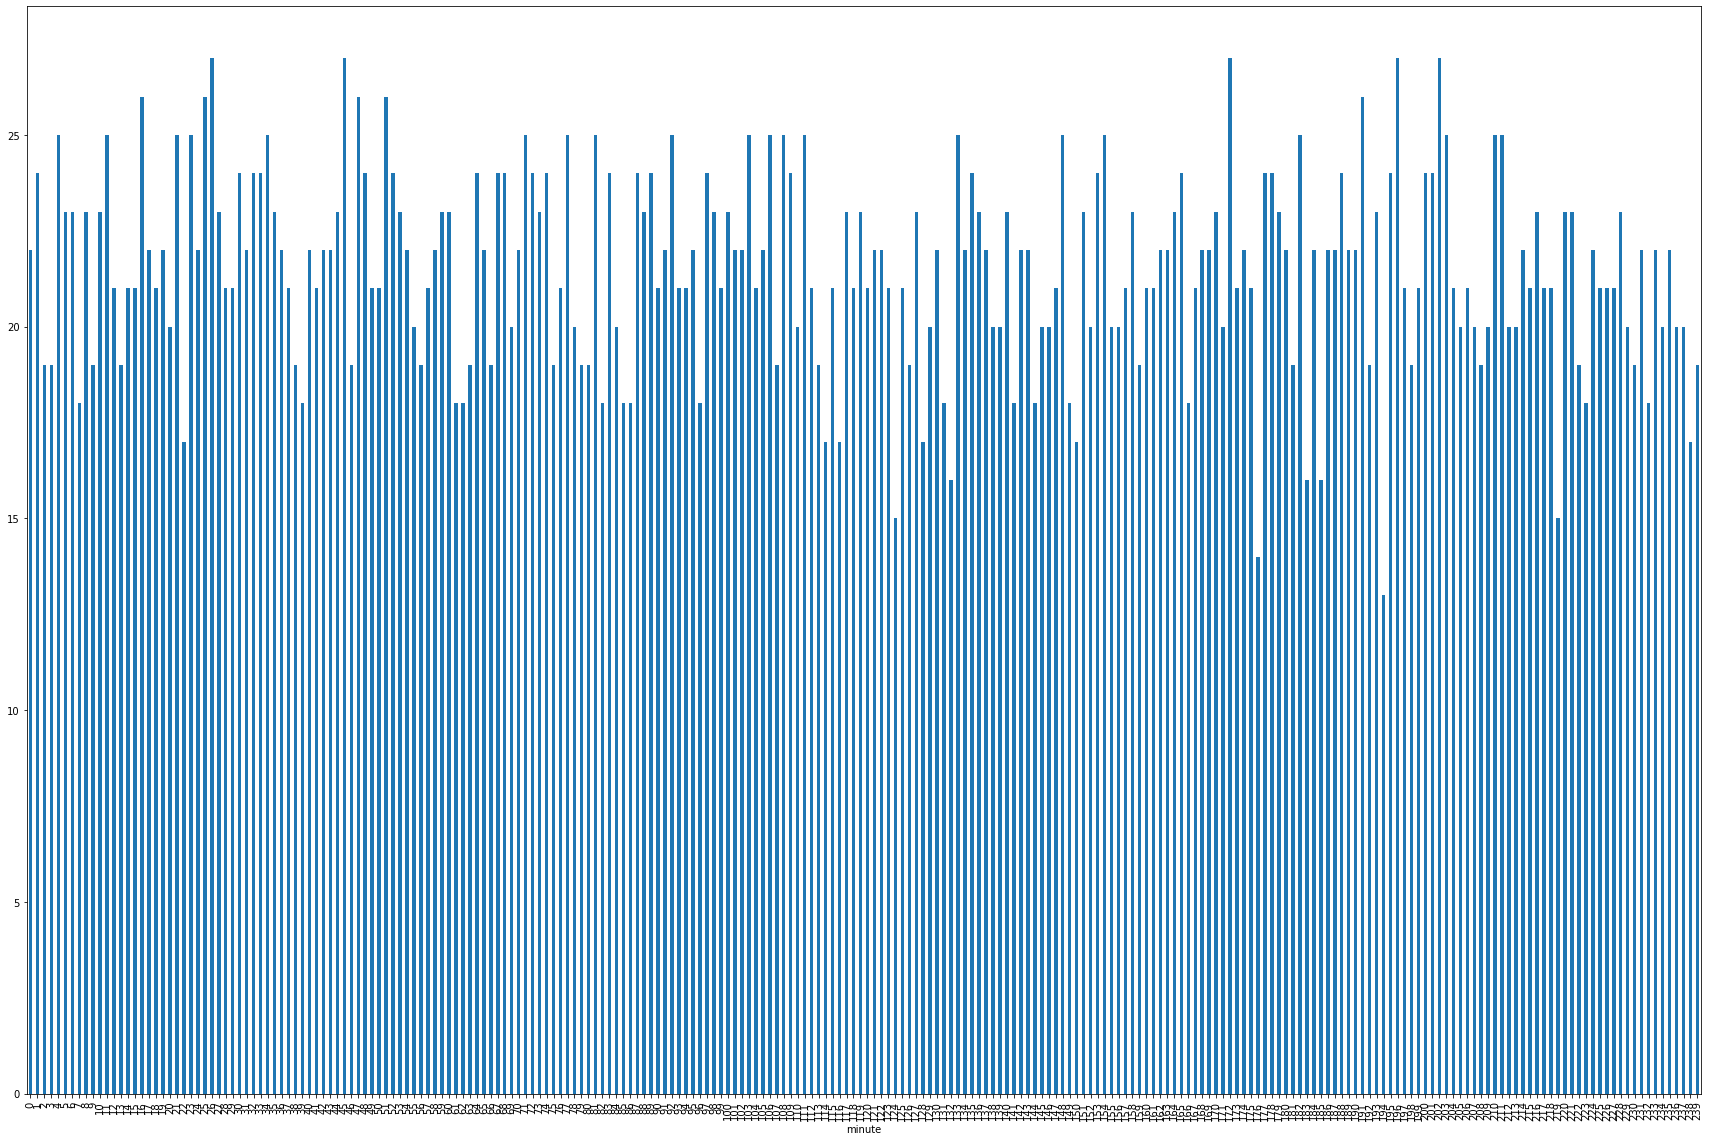

In [190]:
minute_counts.plot(kind="bar", figsize=(30,20))